In [1]:
import datajoint as dj

In [2]:
import sys
sys.path.append('c:\\Users\\liul.HHMI\\Desktop\\map-ephys\\pipeline') # go to parent dir
sys.path.append('c:\\Users\\liul.HHMI\\Desktop\\map-ephys\\scripts')
sys.path.append('c:\\Users\\liul.HHMI\\Desktop\\map-ephys\\development')
sys.path.append('c:\\Users\\liul.HHMI\\Desktop\\map-lab')

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [5]:
import ephys

Connecting daveliu@mesoscale-activity.datajoint.io:3306


In [ ]:
dj.ERD(ephys)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as sp

In [6]:
behaviorT=ephys.experiment.BehaviorTrial()

In [85]:
animal = 399752
sessionN = 22
#animal = 407513
#sessionN = 10
contraH=(behaviorT & {'subject_id': animal} & {'session': sessionN} & 'outcome = "hit"' & 'trial_instruction = "right"' & 'early_lick = "no early"').fetch('trial')
ipsiH=(behaviorT & {'subject_id': animal} & {'session': sessionN} & 'outcome = "hit"' & 'trial_instruction = "left"' & 'early_lick = "no early"').fetch('trial')
contraE=(behaviorT & {'subject_id': animal} & {'session': sessionN} & 'outcome = "miss"' & 'trial_instruction = "right"' & 'early_lick = "no early"').fetch('trial')
ipsiE=(behaviorT & {'subject_id': animal} & {'session': sessionN} & 'outcome = "miss"' & 'trial_instruction = "left"' & 'early_lick = "no early"').fetch('trial')

In [86]:
offset=2.95
#offset=3.45

In [8]:
ephys1=ephys.Ephys()

In [87]:
spike=ephys1.Spike()
unit=ephys1.Unit()

In [88]:
goodUnits=(unit & {'subject_id': animal} & {'session': sessionN} & {'unit_quality': 'good'}).fetch('unit')
goodUnits

array([  0,   1,   2,  17,  18,  25,  26,  28,  31,  32,  33,  36,  38,
        42,  44,  45,  46,  47,  48,  50,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  66,  68,  69,  70,  75,  77,  78,  83,
        88,  89,  91, 106], dtype=int64)

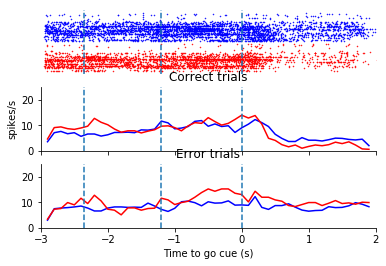

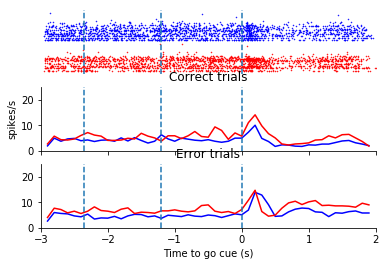

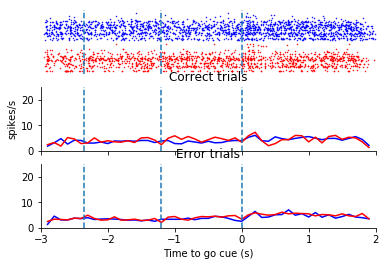

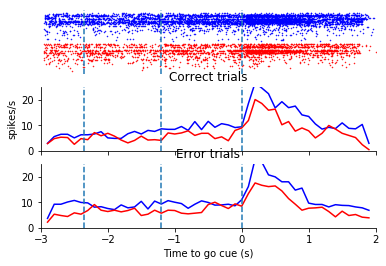

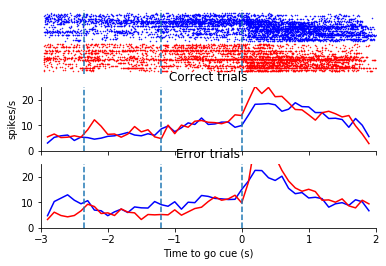

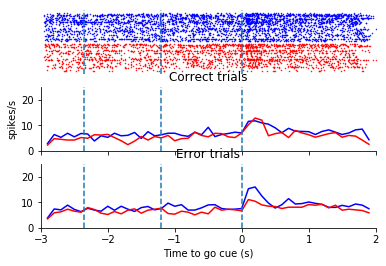

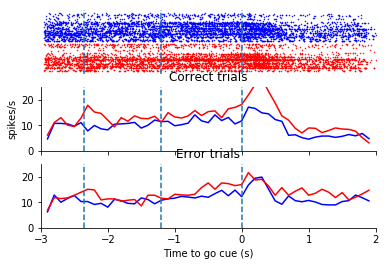

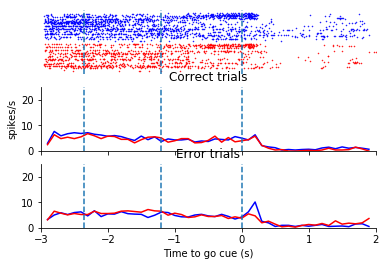

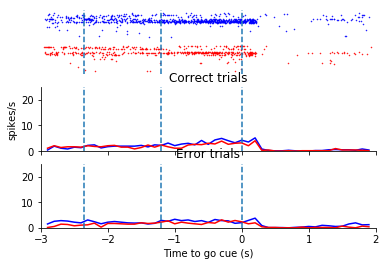

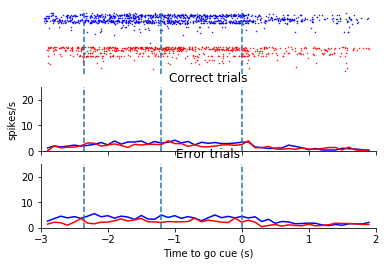

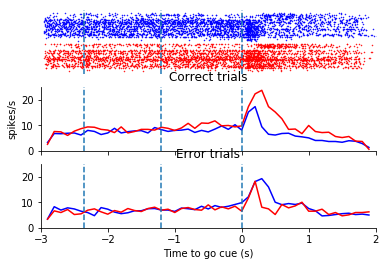

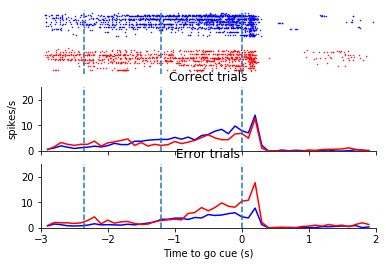

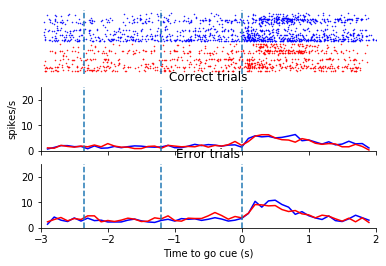

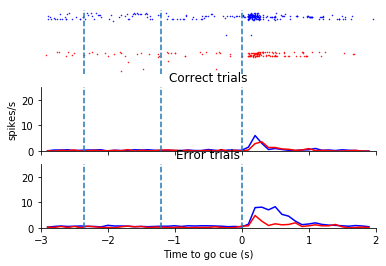

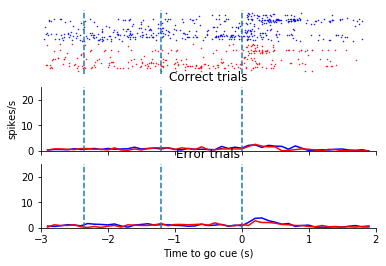

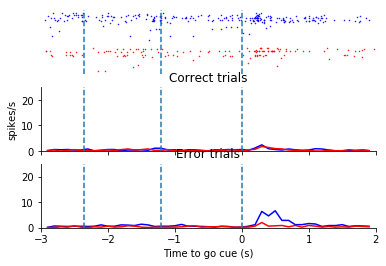

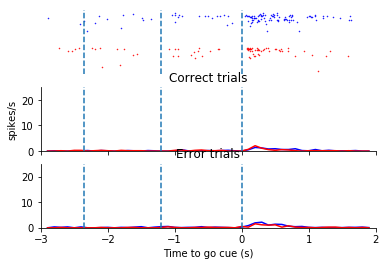

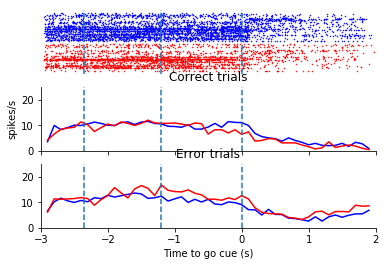

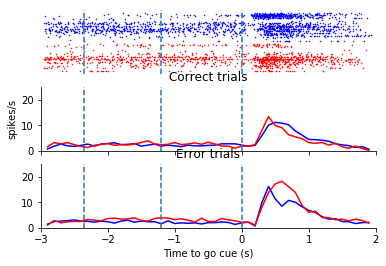

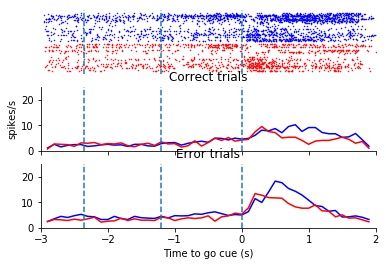

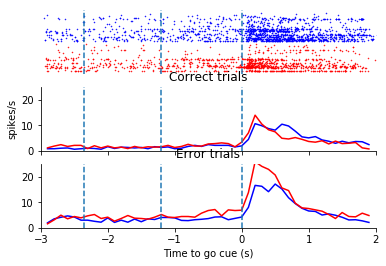

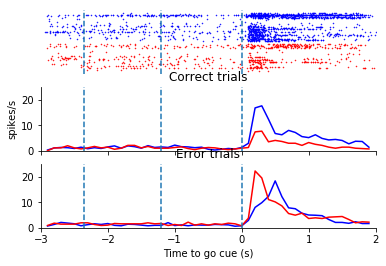

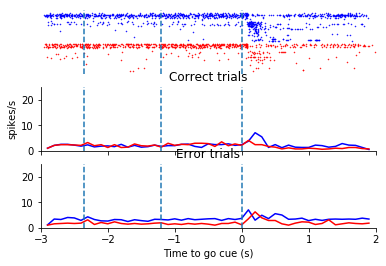

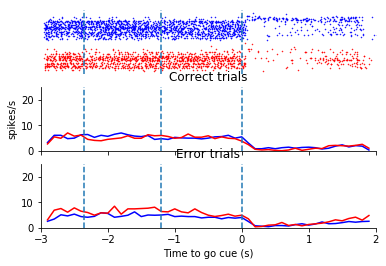

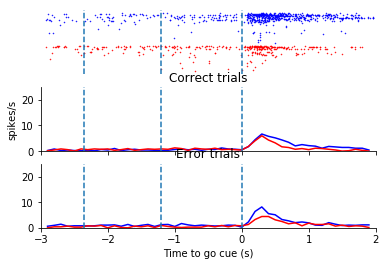

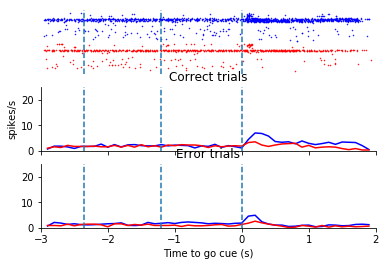

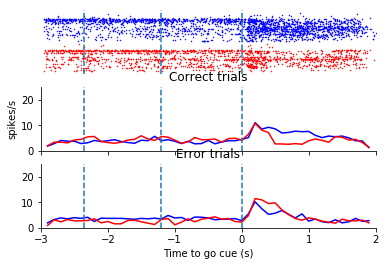

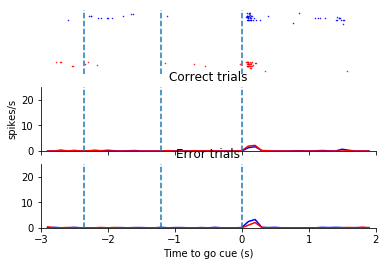

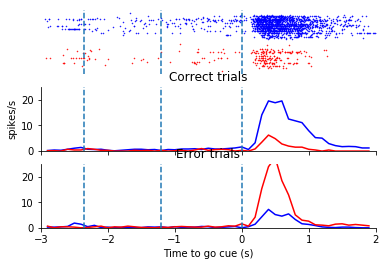

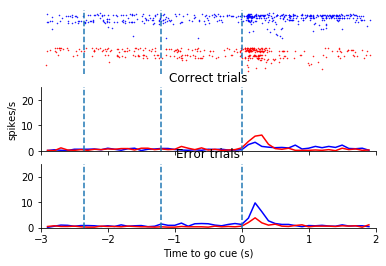

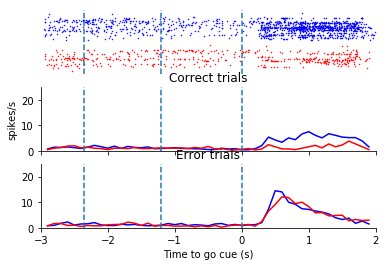

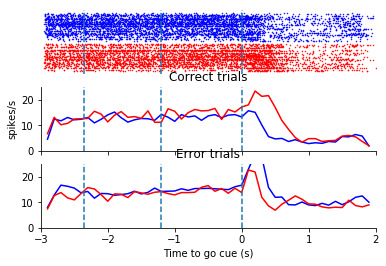

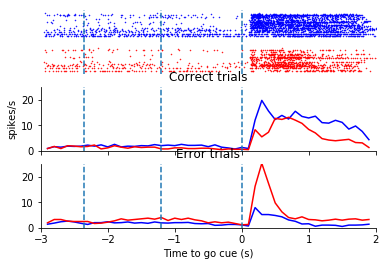

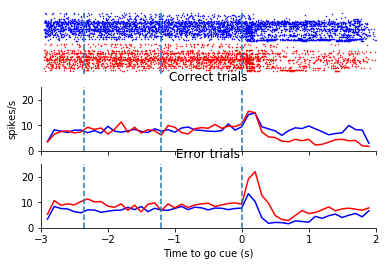

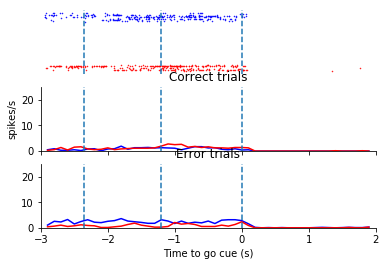

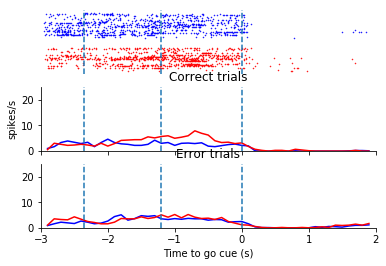

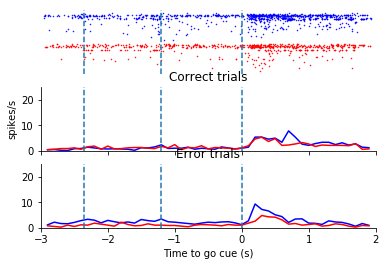

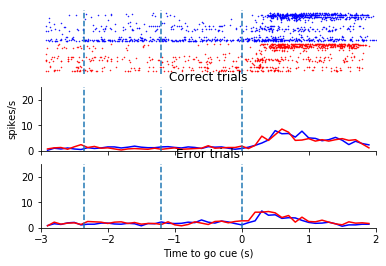

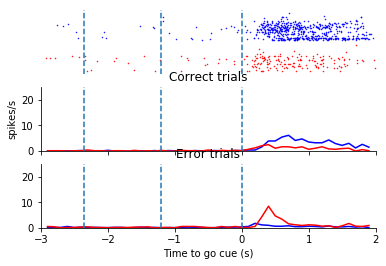

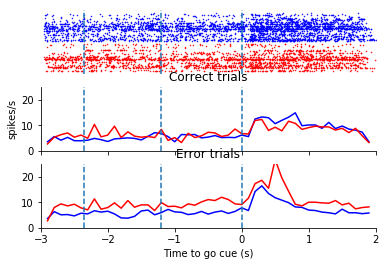

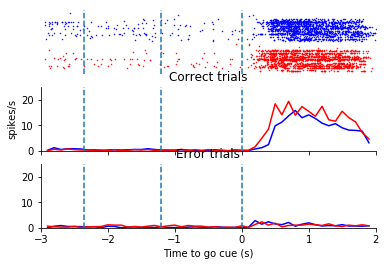

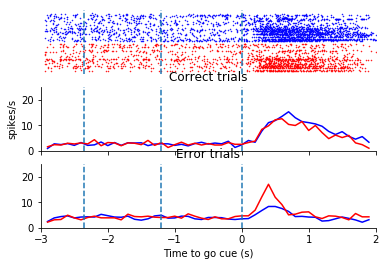

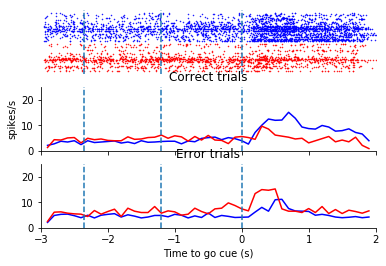

In [93]:
for x in goodUnits:
    unit1=(spike & {'unit': x} & {'subject_id': animal} & {'session': sessionN}).fetch('spike_time','trial')
    binSize=0.1;
    plt.figure()
    ax=plt.subplot(311)
    plt.plot(np.asarray(unit1[0][np.in1d(unit1[1],contraH)], dtype='float')-offset,unit1[1][np.in1d(unit1[1],contraH)]+500,'b.',markersize=1)
    plt.plot(np.asarray(unit1[0][np.in1d(unit1[1],ipsiH)], dtype='float')-offset,unit1[1][np.in1d(unit1[1],ipsiH)],'r.',markersize=1)
    ax.set_axis_off()
    ax.set_xlim([-3, 2])
    ax.axvline(0,0,1, ls='--')
    ax.axvline(-1.2,0,1, ls='--')
    ax.axvline(-2.35,0,1, ls='--')
    ax = plt.subplot(312)
    psth=np.histogram(np.asarray(unit1[0][np.in1d(unit1[1],contraH)], dtype='float')-offset,bins=np.arange(-3,2,binSize))
    plt.plot(psth[1][1:],psth[0]/len(contraH)/binSize, 'b')
    psth=np.histogram(np.asarray(unit1[0][np.in1d(unit1[1],ipsiH)], dtype='float')-offset,bins=np.arange(-3,2,binSize))
    plt.plot(psth[1][1:],psth[0]/len(ipsiH)/binSize, 'r')
    plt.ylabel('spikes/s')
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_xlim([-3, 2])
    ax.set_ylim([0, 25])
    ax.set_xticklabels([])
    ax.axvline(0,0,1, ls='--')
    ax.axvline(-1.2,0,1, ls='--')
    ax.axvline(-2.35,0,1, ls='--')
    plt.title('Correct trials')
    ax = plt.subplot(313)
    psth=np.histogram(np.asarray(unit1[0][np.in1d(unit1[1],contraE)], dtype='float')-offset,bins=np.arange(-3,2,0.1))
    plt.plot(psth[1][1:],psth[0]/len(contraE)/binSize, 'b')
    psth=np.histogram(np.asarray(unit1[0][np.in1d(unit1[1],ipsiE)], dtype='float')-offset,bins=np.arange(-3,2,0.1))
    plt.plot(psth[1][1:],psth[0]/len(ipsiE)/binSize, 'r')
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_xlim([-3, 2])
    ax.set_ylim([0, 25])
    ax.axvline(0,0,1, ls='--')
    ax.axvline(-1.2,0,1, ls='--')
    ax.axvline(-2.35,0,1, ls='--')
    plt.title('Error trials')
    plt.xlabel('Time to go cue (s)')

In [65]:
selectC=[]
selectI=[]
binSize=0.1
for x in goodUnits:
    unit1=(spike & {'unit': x} & {'subject_id': animal} & {'session': sessionN}).fetch('spike_time','trial') # find good neurons
    psthC=np.histogram(np.asarray(unit1[0][np.in1d(unit1[1],contraH)], dtype='float')-offset,bins=np.arange(-3,2,binSize))
    psthI=np.histogram(np.asarray(unit1[0][np.in1d(unit1[1],ipsiH)], dtype='float')-offset,bins=np.arange(-3,2,binSize)) 
    if len(unit1[0][np.in1d(unit1[1],contraH)])/len(contraH) > len(unit1[0][np.in1d(unit1[1],ipsiH)])/len(ipsiH):
        if len(selectC) == 0:
            selectC=(psthC[0]/len(contraH)-psthI[0]/len(ipsiH))/max(psthC[0]/len(contraH)-psthI[0]/len(ipsiH))
        elif len(selectC) != 0:
            selectC=np.vstack((selectC, (psthC[0]/len(contraH)-psthI[0]/len(ipsiH))/max(psthC[0]/len(contraH)-psthI[0]/len(ipsiH))))
    elif len(unit1[0][np.in1d(unit1[1],contraH)])/len(contraH) < len(unit1[0][np.in1d(unit1[1],ipsiH)])/len(ipsiH):
        if len(selectI) == 0:
            selectI=(psthI[0]/len(ipsiH)-psthC[0]/len(contraH))/min(psthC[0]/len(contraH)-psthI[0]/len(ipsiH))
        elif len(selectI) != 0:
            selectI=np.vstack((selectI, (psthI[0]/len(ipsiH)-psthC[0]/len(contraH))/min(psthC[0]/len(contraH)-psthI[0]/len(ipsiH))))

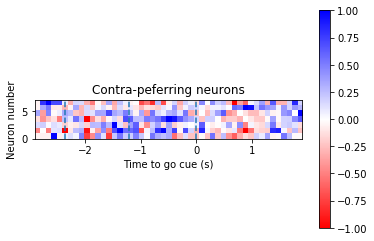

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(selectC[:][:],vmin=-1, vmax=1, extent=[psthC[1][1], psthC[1][-1], 0, len(selectC)])
plt.colorbar()
plt.set_cmap('bwr_r')
ax.set_aspect(0.1)
plt.title('Contra-preferring neurons')
plt.ylabel('Neuron number')
plt.xlabel('Time to go cue (s)')
ax.axvline(0,0,1, ls='--')
ax.axvline(-1.2,0,1, ls='--')
ax.axvline(-2.35,0,1, ls='--')

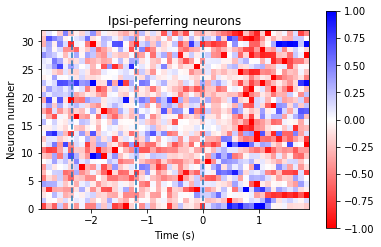

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(selectI[:][:],vmin=-1, vmax=1, extent=[psthI[1][1],psthI[1][-1],0, len(selectI)])
plt.colorbar()
plt.set_cmap('bwr_r')
ax.set_aspect(0.1)
plt.title('Ipsi-preferring neurons')
plt.ylabel('Neuron number')
plt.xlabel('Time (s)')
ax.axvline(0,0,1, ls='--')
ax.axvline(-1.2,0,1, ls='--')
ax.axvline(-2.35,0,1, ls='--')

In [40]:
sCg=np.empty(len(goodUnits))
sEg=np.empty(len(goodUnits))
sCd=np.empty(len(goodUnits))
sEd=np.empty(len(goodUnits))
sCs=np.empty(len(goodUnits))
sEs=np.empty(len(goodUnits))
count=0
for x in goodUnits: # choice related activity
    unit1=(spike & {'unit': x} & {'subject_id': animal} & {'session': sessionN}).fetch('spike_time','trial') # find high firing neurons
    spkC=np.asarray(unit1[0][np.in1d(unit1[1],contraH)], dtype='float')-offset
    spkI=np.asarray(unit1[0][np.in1d(unit1[1],ipsiH)], dtype='float')-offset
    spkCE=np.asarray(unit1[0][np.in1d(unit1[1],contraE)], dtype='float')-offset
    spkIE=np.asarray(unit1[0][np.in1d(unit1[1],ipsiE)], dtype='float')-offset
    sCg[count]=len(spkC[(spkC<2) & (spkC>0)])/len(contraH)-len(spkI[(spkI<2) & (spkI>0)])/len(ipsiH)
    sEg[count]=len(spkCE[(spkCE<2) & (spkCE>0)])/len(contraE)-len(spkIE[(spkIE<2) & (spkIE>0)])/len(ipsiE)
    sCd[count]=len(spkC[(spkC<0) & (spkC>-1.2)])/len(contraH)-len(spkI[(spkI<0) & (spkI>-1.2)])/len(ipsiH)
    sEd[count]=len(spkCE[(spkCE<0) & (spkCE>-1.2)])/len(contraE)-len(spkIE[(spkIE<0) & (spkIE>-1.2)])/len(ipsiE)
    sCs[count]=len(spkC[(spkC<-1.2) & (spkC>-2.35)])/len(contraH)-len(spkI[(spkI<-1.2) & (spkI>-2.35)])/len(ipsiH)
    sEs[count]=len(spkCE[(spkCE<-1.2) & (spkCE>-2.35)])/len(contraE)-len(spkIE[(spkIE<-1.2) & (spkIE>-2.35)])/len(ipsiE)

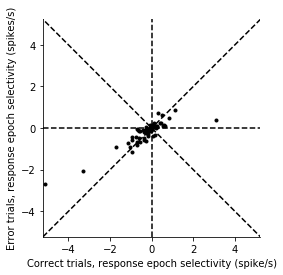

In [45]:
ax=plt.subplot(111)
plt.plot(sCd,sCs,'k.',[-15, 15], [-15, 15],'k--',[-15, 15], [15, -15],'k--')
plt.xlabel('Correct trials, response epoch selectivity (spike/s)')
plt.ylabel('Error trials, response epoch selectivity (spikes/s)')
plt.xlim(-max(sC), max(sC))
plt.ylim(-max(sC), max(sC))
plt.gca().set_aspect('equal', adjustable='box')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.axvline(0,0,1, ls='--', color='k')
ax.axhline(0,0,1, ls='--', color='k')

In [44]:
np.corrcoef(sCs, sCd)

array([[1.       , 0.9472278],
       [0.9472278, 1.       ]])

In [43]:
from scipy.stats import linregress
linregress(sCg, sEd)

LinregressResult(slope=-0.14872347508895747, intercept=-0.1936852117781154, rvalue=-0.4642354049169261, pvalue=2.398604011234475e-05, stderr=0.03298510441662636)

In [ ]:
# noise correlation

In [94]:
import h5py
import numpy as np
import scipy.io as spio

c:\users\liul.hhmi\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [96]:
#file="C:\\Users\liul.HHMI\Desktop\\tw5ap_imec3_opt3_jrc.mat"
file="C:\\Users\liul.HHMI\Desktop\\dl25_bitcode.mat"
mat = spio.loadmat(file, squeeze_me = True)

In [116]:
bitCodeE = mat['bitCodeS'].flatten()
bitCodeE[0]

'0011001100010011'

In [112]:
trialNote=ephys.experiment.TrialNote()
bitCodeB=(trialNote & {'subject_id': animal} & {'session': sessionN} & {'trial_note_type' : 'bitcode'}).fetch('trial_note', order_by='trial')
bitCodeB[0]

'0011010111010010'

In [114]:
if len(bitCodeB) < len(bitCodeE) # behavior file is shorter


464

In [91]:
unit1=(spike & {'unit': goodUnits[11]} & {'subject_id': animal} & {'session': sessionN}).fetch('electrode')

In [92]:
unit1

array([14, 12, 12, ..., 12, 12, 12], dtype=int64)

In [ ]:
140